## **0. Setup**

In [1]:
import scikit_posthocs as sp

In [97]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# my_pal = ['grey', 'mediumseagreen']
my_pal = ['grey', 'mediumseagreen', 'dodgerblue', 'darkviolet', 'yellow']

# set the directory where the data files are waiting
directory = '/Users/ShokenLEE/Desktop/DATA/Common data spreadsheets/nLD/RNAi/'
# directory = '/Users/ShokenLEE/Desktop/DATA/Common data spreadsheets/nLD/OE/'
# directory = '/Users/ShokenLEE/Desktop/DATA/Common data spreadsheets/nLD/Basal/Sun2/'

In [24]:
micron_per_pixel = 0.23

## **1. Concanatate all the CSV files**

In [98]:
df = pd.DataFrame() # for nuclear protein and DAPI intensity data
df_LD = pd.DataFrame() # for LD data

for path, subdirs, files in os.walk(directory):
    for file in files:
        if (file.endswith('csv')) & ('ROI' not in file):
            _df = pd.read_csv(os.path.join(path, file))
            _df['Path'] = path
            df = pd.concat([df, _df], axis=0)
        elif (file.endswith('csv')) & ('ROI' in file):
            _df = pd.read_csv(os.path.join(path, file))
            df_LD = pd.concat([df_LD, _df], axis=0)

In [99]:
# rename columns
df = df.rename(columns={' ': 'ROI_number'})
df_LD = df_LD[[' ', 'Area', 'File name', 'ROI_number']]

In [100]:
df.info()
# df_LD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229 entries, 0 to 11
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ROI_number  1229 non-null   int64  
 1   Area        1229 non-null   float64
 2   Mean        1229 non-null   float64
 3   Circ.       1229 non-null   float64
 4   AR          1229 non-null   float64
 5   Round       1229 non-null   float64
 6   Solidity    1229 non-null   float64
 7   DAPI mean   1229 non-null   float64
 8   File name   1229 non-null   object 
 9   Path        1229 non-null   object 
dtypes: float64(7), int64(1), object(2)
memory usage: 105.6+ KB


#### Check the number of files

In [101]:
print(len(df['File name'].unique()), len(df_LD['File name'].unique()))

99 99


## **2. Summerize LD data**

In [102]:
# total area and number (count) of LD per nucleus
df_LD_sumArea = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].sum().rename(columns={'Area': 'total_nLD_area'})
df_LD_count = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].count().rename(columns={'Area': 'number_of_nLD'})

# Merged the two above to summarize LD data
df_LD_summary = df_LD_count.merge(df_LD_sumArea, on=['File name', 'ROI_number'])

# Merge the LD data above to the df of nuclear protein and DAPI intensity data
df = df.merge(df_LD_summary, how='outer', on=['File name', 'ROI_number'])

# fill NA with 0
df.fillna(0, inplace=True)

## **3. Group cell/condition types**

#### **Prepare column order for graphs**

In [103]:
# Groups (conditions) and its order in graphs
group_name_options = ['siRNA type', 'Plasmid type']
group_order_options = [
    ['siCtrl', 'siSun2', 'siSun1', 'siCTDNEP1'],
    ['Mock', 'WT', '2SA', '2SA_LVWA', 'Sun1']
]

group_name = group_name_options[0]
group_order = group_order_options[0]

# Hues
hue_name_options = ['Experiments', 'Sun2_OE']
hue_order_options = [
    ['t1', 't2'],
    ['(-)', '(+)']
]

hue_name = hue_name_options[1]
hue_order = hue_order_options[1]

#### **Cell type**

In [19]:
df.loc[df['File name'].str.contains('Sctrl'), 'Cell type'] = 'Control'
df.loc[df['File name'].str.contains('CTDNEP1'), 'Cell type'] = 'CTDNEP1 KO'

#### **siRNA type**

In [104]:
df.loc[df['File name'].str.contains('siCtrl'), 'siRNA type'] = group_order[0]
df.loc[df['File name'].str.contains('siSun2'), 'siRNA type'] = group_order[1]
df.loc[df['File name'].str.contains('siSun1'), 'siRNA type'] = group_order[2]
df.loc[df['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = group_order[3]

#### **Plasmid type**

In [36]:
df.loc[df['File name'].str.contains('mock'), 'Plasmid type'] = group_order[0]
df.loc[df['File name'].str.contains('WT '), 'Plasmid type'] = group_order[1]
df.loc[df['File name'].str.contains('SA '), 'Plasmid type'] = group_order[2]
df.loc[df['File name'].str.contains('SA-LVWA'), 'Plasmid type'] = group_order[3]
df.loc[df['File name'].str.contains('Sun1'), 'Plasmid type'] = group_order[4]

#### **Experiments**

In [19]:
df.loc[df['Path'].str.contains('P-225'), 'Experiments'] = hue_order[0]
df.loc[df['Path'].str.contains('P-235'), 'Experiments'] = hue_order[1]

#### **Sun2 OE Cutoff**

In [37]:
# Set the threshold
min_tag_intensity = 3000

# Sort Tag mean based on the threshold
df['Sun2_OE'] = df.apply(lambda x: '(+)' if x['Mean'] > min_tag_intensity else '(-)', axis=1)

#### **Select data only mock cells or cells with Sun2 OE detected**

In [38]:
df = pd.concat([df[df['Sun2_OE'] == '(+)'], df[df['Plasmid type'] == 'Mock']], axis=0)

#### **Image number**

In [105]:
df['Image number'] = df['File name'].str[-7:-4]

# Check the number is correctly extracted
print(list(df['Image number'].unique())[1])

006


## **4. Analysis**

In [108]:
# nLD area per nucleus
df['nLD_area_fraction'] = df.total_nLD_area / df.Area

# Relative nLD_are_fraction normalized to the mean value of control condition
control = {'siRNA type': 'siCtrl', 'Plasmid type': 'Mock'}

mean_nLD_fraction_of_control = df[(df.number_of_nLD > 0) & (df[group_name] == control[group_name])]['nLD_area_fraction'].mean()
df['Relative_nLD_area_fraction'] = df.nLD_area_fraction / mean_nLD_fraction_of_control

## **4-1. Sample size**

In [41]:
df.groupby([hue_name]).size()

Sun2_OE
(+)    594
(-)    138
dtype: int64

## **4-2. Frequency of cells that have nLD**

In [42]:
# _df_1: n of total cells; _df_2: n of cells with nLD
_df_1 = df.groupby([hue_name], as_index=False).size().rename(columns={'size': 'number_of_cells'})
_df_2 = df[df.number_of_nLD > 0].groupby([hue_name], as_index=False).size().rename(columns={'size': 'number_of_cells_w_nLD'})
df_n_cells = _df_1.merge(_df_2, on=[hue_name])

df_n_cells['% of cells with nLD'] = df_n_cells.number_of_cells_w_nLD / df_n_cells.number_of_cells * 100
df_n_cells.to_excel(directory + '/n_of_cells.xlsx', index_label=False)
df_n_cells

,Sun2_OE,number_of_cells,number_of_cells_w_nLD,% of cells with nLD
0,(+),594,392,65.993266
1,(-),138,78,56.521739


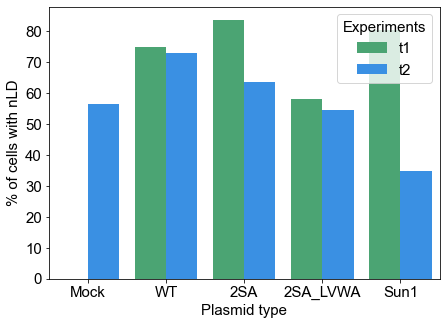

In [44]:
fig = plt.figure(figsize=(7,5))
ax = sns.barplot(data= df_n_cells, x=group_name, y='% of cells with nLD',
                 order=group_order, hue=hue_name, hue_order=hue_order,
                palette=my_pal[1:3])

In [45]:
fig.savefig(directory + '/%cells_w_nLD.pdf', bbox_inches='tight', transparent=True)

## **4-3. nLD area per nucleus**

Text(0, 0.5, 'Relative_area')

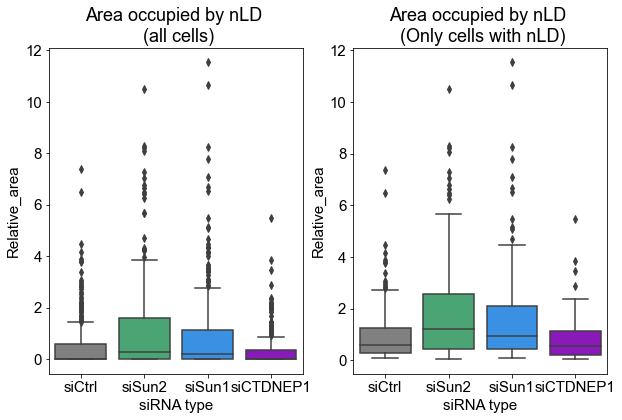

In [109]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(data=df, x=group_name, order=group_order, y='Relative_nLD_area_fraction', palette=my_pal)
plt.title('Area occupied by nLD \n (all cells)')
plt.ylabel('Relative_area')

ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='Relative_nLD_area_fraction', palette=my_pal)
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Relative_area')

In [48]:
fig.savefig(directory + '/nLD_area_fraction.pdf', bbox_inches='tight', transparent=True)

In [49]:
df[df['number_of_nLD']>0].groupby([group_name, hue_name])['Relative_nLD_area_fraction'].mean()

Plasmid type  Experiments
2SA           t1             0.653290
              t2             0.564069
2SA_LVWA      t1             0.553428
              t2             1.412618
Mock          t2             1.000000
Sun1          t1             0.777323
              t2             0.546602
WT            t1             1.209314
              t2             0.685385
Name: Relative_nLD_area_fraction, dtype: float64

In [56]:
res = pairwise_tukeyhsd(df[df.number_of_nLD > 0]['Relative_nLD_area_fraction'], df[df.number_of_nLD > 0][group_name], alpha=0.05)
print(res)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     2SA 2SA_LVWA    0.395 0.0351  0.0175 0.7724   True
     2SA     Mock   0.3883 0.0575 -0.0074 0.7841  False
     2SA     Sun1   0.0872    0.9 -0.3735 0.5479  False
     2SA       WT   0.2905 0.1606 -0.0618 0.6428  False
2SA_LVWA     Mock  -0.0066    0.9  -0.436 0.4228  False
2SA_LVWA     Sun1  -0.3077  0.424 -0.7976 0.1821  False
2SA_LVWA       WT  -0.1044    0.9 -0.4941 0.2852  False
    Mock     Sun1  -0.3011 0.4761 -0.8053  0.203  False
    Mock       WT  -0.0978    0.9 -0.5053 0.3097  False
    Sun1       WT   0.2033 0.7343 -0.2675 0.6741  False
-------------------------------------------------------


In [111]:
sp.posthoc_dunn(df[df.number_of_nLD > 0], val_col='Relative_nLD_area_fraction', group_col=group_name, p_adjust = None)

,siCTDNEP1,siCtrl,siSun1,siSun2
siCTDNEP1,1.000000e+00,0.252383,0.000011,9.963278e-07
siCtrl,2.523825e-01,1.000000,0.000305,3.038601e-05
siSun1,1.062642e-05,0.000305,1.000000,4.323480e-01
siSun2,9.963278e-07,0.000030,0.432348,1.000000e+00


## **4-4. Number of nLD per nucleus**

(0.0, 20.0)

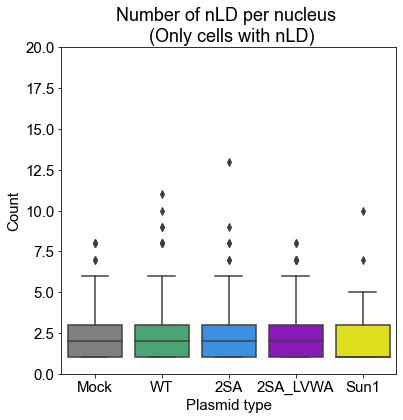

In [52]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(111)
ax1 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
plt.title('Number of nLD per nucleus \n (Only cells with nLD)')
plt.ylabel('Count')
plt.ylim([0,20])

In [53]:
fig.savefig(directory + '/number_of_nLD_per_nucleus.pdf', bbox_inches='tight', transparent=True)

In [54]:
df[df['number_of_nLD']>0].groupby(group_name)['number_of_nLD'].mean()

Plasmid type
2SA         2.451852
2SA_LVWA    2.560440
Mock        2.576923
Sun1        2.200000
WT          2.474138
Name: number_of_nLD, dtype: float64

In [57]:
res = pairwise_tukeyhsd(df[df.number_of_nLD > 0]['number_of_nLD'], df[df.number_of_nLD > 0][group_name], alpha=0.05)
print(res)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     2SA 2SA_LVWA   0.1086    0.9  -0.639 0.8562  False
     2SA     Mock   0.1251    0.9 -0.6589  0.909  False
     2SA     Sun1  -0.2519    0.9 -1.1644 0.6607  False
     2SA       WT   0.0223    0.9 -0.6755 0.7201  False
2SA_LVWA     Mock   0.0165    0.9  -0.834  0.867  False
2SA_LVWA     Sun1  -0.3604 0.8279 -1.3308 0.6099  False
2SA_LVWA       WT  -0.0863    0.9 -0.8582 0.6856  False
    Mock     Sun1  -0.3769 0.8186 -1.3755 0.6217  False
    Mock       WT  -0.1028    0.9 -0.9099 0.7043  False
    Sun1       WT   0.2741    0.9 -0.6584 1.2066  False
-------------------------------------------------------


## **4-5. Individual nLD size (not quantifiable with Sun2 OE experiment)**

Text(0, 0.5, 'Area (square micron)')

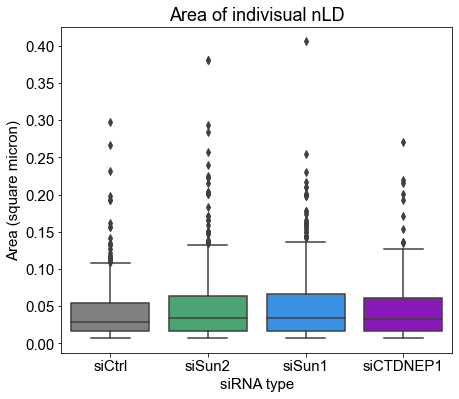

In [144]:
# group siRNA type
df_LD.loc[df_LD['File name'].str.contains('siCtrl'), 'siRNA type'] = group_order[0]
df_LD.loc[df_LD['File name'].str.contains('siSun2'), 'siRNA type'] = group_order[1]
df_LD.loc[df_LD['File name'].str.contains('siSun1'), 'siRNA type'] = group_order[2]
df_LD.loc[df_LD['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = group_order[3]

# convert pixel sq to micron sq
df_LD['Area_micronsq'] = df_LD.Area * np.square(micron_per_pixel)

fig = plt.figure(figsize=(7,6))
ax1 = sns.boxplot(data=df_LD, x=group_name, y='Area_micronsq', 
                  order=group_order, palette=my_pal)

# ax1.text(-1, 0.5, "Mean=")
# for xtick in ax1.get_xticks():
#     ax1.text(xtick-0.3, 0.5, xtick)

plt.title('Area of indivisual nLD')
plt.ylabel('Area (square micron)')

### Tukey test

In [180]:
res = pairwise_tukeyhsd(df_LD['Area_micronsq'], df_LD['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl  -0.0048 0.5855 -0.0146 0.0051  False
siCTDNEP1 siSun1   0.0018    0.9 -0.0074 0.0109  False
siCTDNEP1 siSun2   0.0021    0.9  -0.007 0.0112  False
   siCtrl siSun1   0.0065 0.1024 -0.0008 0.0138  False
   siCtrl siSun2   0.0069 0.0726 -0.0004 0.0141  False
   siSun1 siSun2   0.0003    0.9  -0.006 0.0067  False
------------------------------------------------------


In [145]:
df_LD.groupby(['siRNA type']).size()

siRNA type
siCTDNEP1    202
siCtrl       384
siSun1       618
siSun2       649
dtype: int64

In [146]:
fig.savefig(directory + '/Area_individual_nLD.pdf', bbox_inches='tight', transparent=True)

##### **Background subtraction from C3 intensity value**

In [45]:
background_C3 = 1800

df['C3 mean - background'] = df['Mean'] - background_C3

## **5. Scatter plot (nLD area vs Sun2/Sun1 intensity)**

<Figure size 360x360 with 0 Axes>

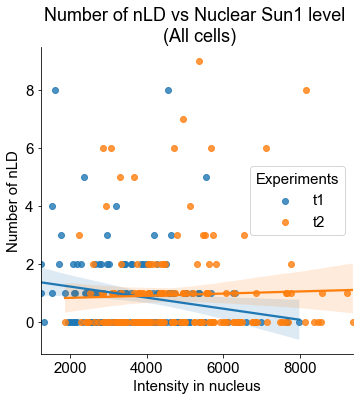

In [52]:
fig = plt.figure(figsize=(5, 5))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df, hue=hue_name, hue_order=hue_order, legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

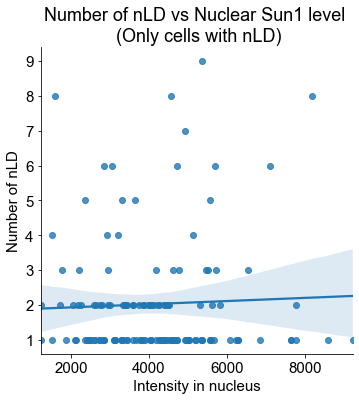

In [47]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

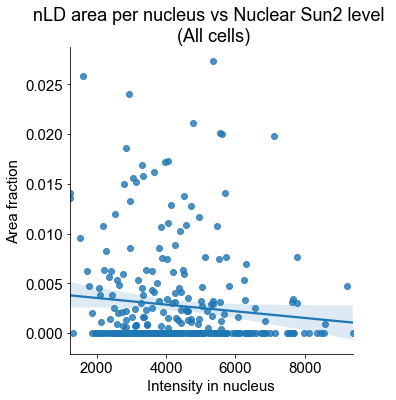

In [62]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df[df.nLD_area_fraction<0.041], markers=['o'], legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun2 level \n (All cells)')

plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun2_all_cells.pdf', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

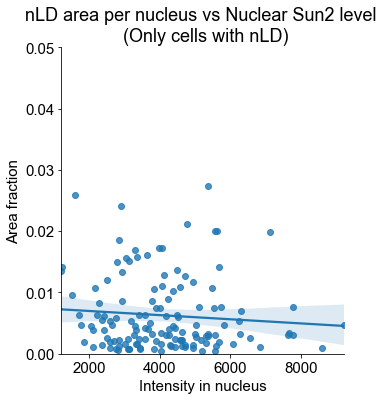

In [64]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df[(df.number_of_nLD > 0)&(df.nLD_area_fraction < 0.04)], legend_out=False)
plt.ylim([0, 0.05])

plt.title('nLD area per nucleus vs Nuclear Sun2 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun1_nLD_cells.pdf', bbox_inches='tight')

### Graphs of nLD area and number

Text(0, 0.5, 'Count')

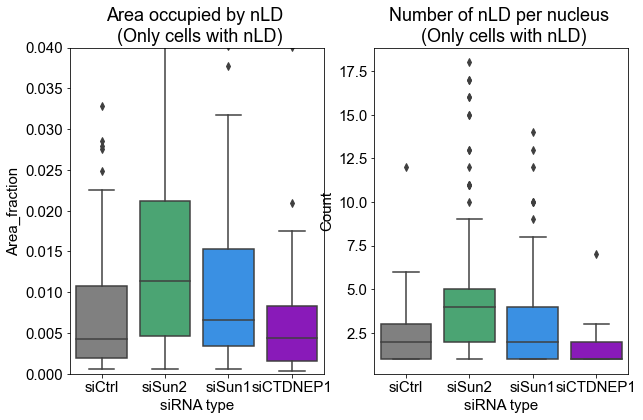

In [57]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig = plt.figure(figsize=(10,6))
# ax_box = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# ax1 = fig.add_subplot(2,2,1)
# ax1 = sns.boxplot(data=df, x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
# plt.title('Area occupied by nLD \n (All cells)')
# plt.ylabel('Area_fraction')
# # plt.legend(bbox_to_anchor=(1.05, 1), title='Sun2 OE', loc='upper left', borderaxespad=0)
# # plt.yscale('log')
# # ax1.spines['top'].set_visible(False)
# # ax_box.spines['right'].set_visible(False)

ax2 = fig.add_subplot(121)
ax2 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
plt.ylim([0, 0.04])
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Area_fraction')

# ax3 = fig.add_subplot(2,2,2)
# ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
# plt.ylim([0.04, 0.1])
# plt.title('Area occupied by nLD \n (Only cells with nLD)')
# plt.ylabel('Area_fraction')

# ax3 = fig.add_subplot(2,2,3)
# ax3 = sns.boxplot(data=df, x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
# plt.title('Number of nLD per nucleus \n (All cells)')
# plt.ylabel('Count')
# # plt.yscale('log')

ax3 = fig.add_subplot(122)
ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
plt.title('Number of nLD per nucleus \n (Only cells with nLD)')
plt.ylabel('Count')
# # plt.yscale('log')